In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const

In [42]:
#Orbital model

"""
Takes as inputs all orbital elements (a, e, I, omega, Omega) as well as a time array, the masses of
objects A (star) and B (planet), and the distance to the system. 

An optional argument is the period - it can be calculated from Kepler's 3rd Law,
but if you want to use an empirical value you can. 

It calculates positions wrt each other and the center of mass location,
as well as the radial velocity function.

"""

def orbits(orbital_elements, t_0, time_array, masses, d, T=None):
    #using coordinate system: AU, M_sun, days
    a, e, I, Omega, omega = orbital_elements
    m_star, m_planet = masses
    mass_ratio = m_star/m_planet
    
    #first make sure everything is in the right units
    omega = np.pi / 180. * omega
    I = np.pi / 180. * I
    Omega = np.pi / 180. * Omega
    d = d.to('AU').value
    
    #input time array as a start date and end date in Julian Days, 
    #t0 should be a time of periastron
    
    #first we can calculate some constants without doing any solvers
    if T is None:
        T_yr = np.sqrt(a**3 / (m_star + m_planet)) #years
        T = T_yr * 365. #days
        print(T)
    #you can use the period as an input if you want. if you don't know it, we can calculate it.
    
    n = 2 * np.pi / T #1/day
    K = (1+mass_ratio)**(-1) * (n * a * np.sin(I)) / np.sqrt(1-e**2) #AU/day
    k = K * u.AU / u.day
    
    #now solve for eccentric anomaly E using Newton's method
    M = []
    for t in time_array:
        m = n * (t - t_0)
        M.append(m)
    M = np.asarray(M)
    
    #this requires the equation to be set to 0, so 0 = E - sinE - M.
    def newton(g, dg, tol, initial_guess=None):
        if initial_guess is None:
            E_arr = []
            initial_guesses = [] #only need this for high eccentricity
            for i in range(0, len(M)):
                if e <= 0.8:
                    initial_guess = M[i]
                    E = initial_guess
                    error = abs(0 - g(E) + M[i])
                    while error > tol:
                        Enew = E - (g(E) - M[i]) / dg(E)
                        error = abs(0 - g(E) + M[i])
                        E = Enew
                    E_arr.append(E)
                    
               #this method begins to break for high eccentricity, because E=M
               #is no longer valid as an initial guess; so we use E(e=0.75) as an initial guess.
                else:
                    initial_guess_e75 = M[i]
                    E = initial_guess_e75
                    
                    error = abs(0 - g(E) + (0.75 - e)*np.sin(E) + M[i])
                    while error > tol:
                        Enew = E - (g(E) - (0.75 - e)*np.sin(E) - M[i]) / (dg(E) - (0.75 - e)*np.cos(E))
                        error = abs(0 - g(E) + (0.75 - e)*np.sin(E) + M[i])
                        E = Enew
                        
                    error = abs(0 - g(E) + M[i])
                    while error > tol:
                        E_final = E - (g(E) - M[i]) / dg(E)
                        error = abs(0 - g(E) + M[i])
                        E = E_final
                        
                    E_arr.append(E)
                    
                    #we will use this as an array of initial guesses for high eccentricities.
                    
            #we want this to converge to the solution g(E) = 0. 
            #The error is the distance from zero.
        else:
            E_arr = []
            for i in range(0, len(M)):
                E = initial_guess
                error = abs(0 - g(E) + M[i])
                while error > tol:
                    E = E - (g(E) - M[i]) / dg(E)
                    error = abs(0 - g(E) + M[i])
                E_arr.append(E)
                    
        E_arr = np.asarray(E_arr)
        return E_arr
    
    #define the functions describing eccentric anomaly  
    def g(E):
        return E - e * np.sin(E)
   
    def dg(E):
        return 1 - e * np.cos(E)
    
    #solve for time-dependent values of E
    E = newton(g, dg, 1.0e-7)   
    f = 2 * np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))

    #now we have the radial velocity:
    def v(f):
        v = -1 * K * (np.cos(omega+f) + e * np.cos(omega)) * u.AU / u.day
        #convert to km/s from AU/day
        v = v.to('km s-1')
        return v
    
    rv = v(f)
    
    #now we can do both COM frame and absolute frame
    r_abs = a * (1 - e * np.cos(E))
    
    a_s = (1+mass_ratio)**(-1) * a; a_p = mass_ratio * (1+mass_ratio)**(-1) * a
    r_com_s = a_s * (1 - e * np.cos(E)); r_com_p = a_p * (1 - e * np.cos(E))
    
    #absolute positions
    x = r_abs * np.cos(f)    
    y = r_abs * np.sin(f)
    
    #relative to COM positions
    x_com_s = r_com_s * np.cos(f)
    y_com_s = r_com_s * np.sin(f)
    x_com_p = r_com_p * np.cos(f)
    y_com_p = r_com_p * np.sin(f)
    
    #use a rotation matrix to get final X and Y positions
    theta = omega + f
    
    X = r_abs * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(I))
    Y = r_abs * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(I))
    Z = r_abs * np.sin(theta) * np.sin(I)
    R = np.sqrt(X**2 + Y**2)
    projected_separation = np.sqrt(X**2 + Y**2) / d * 180. / np.pi * 3600. #arcseconds
    
    PA_abs = (np.arctan2(X, -Y) * 180 / np.pi) + 270. #given in degrees - the 270 rotates our reference axis to North
    
    X_com_s = r_com_s * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(I))
    Y_com_s = r_com_s * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(I))
    proj_sep_com_star = np.sqrt(X_com_s**2 + Y_com_s**2) / d * 180. / np.pi * 3600.
    
    X_com_p = r_com_p * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(I))
    Y_com_p = r_com_p * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(I))
    proj_sep_com_planet = np.sqrt(X_com_p**2 + Y_com_p**2) / d * 180. / np. pi * 3600.
    
    PA_com_s = 270 + np.arctan2(X_com_s, Y_com_s) * 180 / np.pi
    PA_com_p = 270 + np.arctan2(X_com_p, Y_com_p) * 180 / np.pi
    
    return_values = np.array([X, Y, Z, R, projected_separation, PA_abs, proj_sep_com_star,\
                             PA_com_s, PA_com_p, E, x, y, X_com_s, Y_com_s, rv])
    
    return return_values

    #return X, Y, projected_separation, PA_abs, proj_sep_com_star, proj_sep_com_planet, PA_com_s, PA_com_p, rv, x, y, M, E

111.28489026


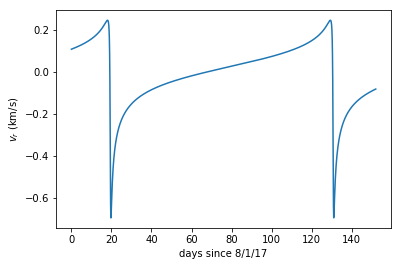

[ 2457986.25047671] [ 2458095.80972487]


"\nConvert these times to UTC using US Navy's site, then -5 for CST\nMax RV occurs on 10/27/17 at 04:46:26\nMin RV occurs on 10/25/17 at 12:01:28\nWe might be able to see max RV.\n"

In [53]:
"""
Question 2#: HD 80606b

mass: 4.0 M_J, a = 0.453 AU, P = 111.436 days, e = 0.9336, i = 89.285, stellar mass = 0.9 M_sun
omega = 300.80 deg, K = 411, Omega = -19.02
should get an rv of 3.6 km/s, but this includes systemic velocity

Julian date of t_0, from literature: 2454424.852 
Julian date of August 1 2017: 2457966.5, December 31 2017: 2458118.5
"""

t_0 = 2454424.852 #JD
aug1 = 2457966.5
dec31 = 2458118.5 #+ 365.
t_arr = np.linspace(aug1, dec31, 24* int(dec31-aug1+1))

orbit_input = np.array([0.449, 0.9332, 89.32, -19.02, 300.80])
m_star = 0.97 * u.M_sun
m_planet = 3.94 * u.M_jup
mass_array = np.array([m_star.value, m_planet.to('M_sun').value])
D = (58.8 * u.pc).to('AU')

HD80606 = orbits(orbit_input, t_0, t_arr, mass_array, D)

rv = HD80606[-1]
plt.plot(t_arr-aug1, rv)
plt.xlabel('days since 8/1/17')
plt.ylabel('$v_r$ (km/s)')
plt.savefig('381_hw1q2.jpg')
plt.show()

rv_max = max(rv)
rv_min = min(rv)
min_loc = np.where(rv==rv_max)[0]
max_loc = np.where(rv==rv_min)[0]
t_rvmax = t_arr[max_loc]
t_rvmin = t_arr[min_loc]
print(t_rvmax, t_rvmin)

"""
Convert these times to UTC using US Navy's site, then -5 for CST
Max RV occurs on 10/27/17 at 04:46:26
Min RV occurs on 10/25/17 at 12:01:28
We might be able to see max RV.
"""

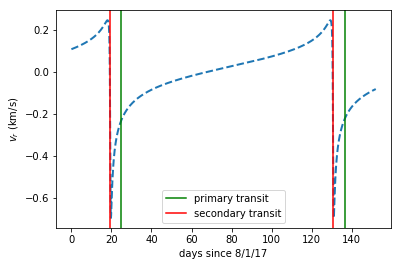

2457985.83642 2458103.17992


In [52]:
"""
Question 3

Transits will be visible when the planet crosses in front of the star, which will be visible
to us when the planet is in a position on the orbit that is within the angular size of the star.

Basically we just need an array of times when the projected separation between the planet and
the star is less than the star + the planet radius.
"""

R_sun = const.R_sun.to('AU')
R_planet = (0.98 * u.R_jup).to('AU')
physical_distance = (58.38 * u.pc).to('AU') #from the literature
angular_size = (R_sun+R_planet)/physical_distance * (180./np.pi * 3600) #arcseconds

Z = HD80606[2]
projected_sep = HD80606[4]
R = HD80606[3]

#primary transit occurs where Z is positive (planet in front of star) and proj_sep < angular_size
transit_p = t_arr[np.where((Z > 0) & (projected_sep < angular_size))]
#secondary transit occurs when Z is negative (planet behind star)
transit_s = t_arr[np.where((Z < 0) & (projected_sep < angular_size))]

plt.plot(t_arr-aug1, rv, linewidth=2, linestyle='--')
plt.axvline(transit_p[0] - aug1, color='g', label='primary transit')
plt.axvline(transit_p[-1] - aug1, color='g')
plt.axvline(transit_s[0] - aug1, color='r', label='secondary transit')
plt.axvline(transit_s[-1] - aug1, color='r')
plt.xlabel('days since 8/1/17')
plt.ylabel('$v_r$ (km/s)')
plt.legend()
plt.savefig('381_hw1q3.jpg')
plt.show()

print(transit_s[0], transit_p[-1])

111.28489026


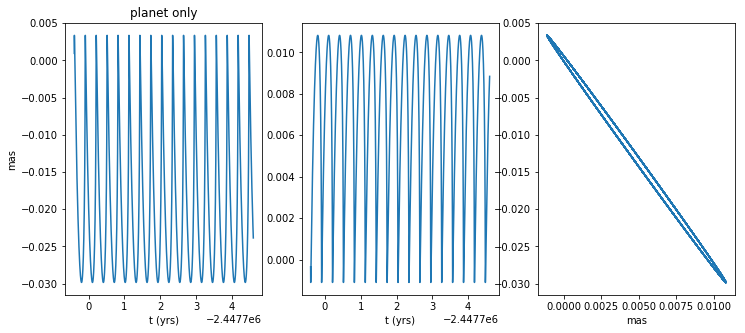

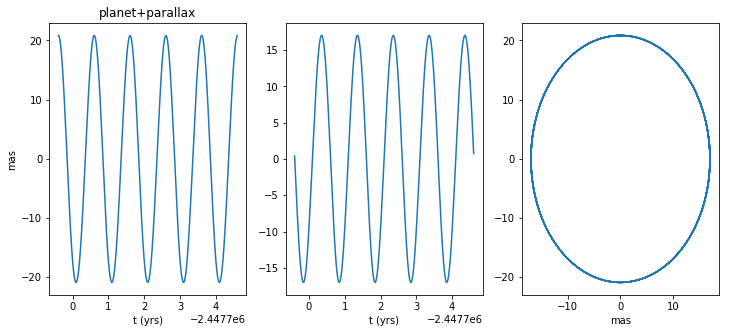

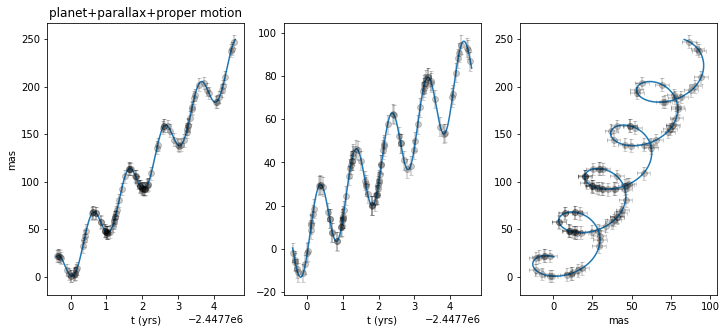

[ 0.00674501  0.00674501  0.00674501 ...,  0.00674502  0.00674502
  0.00674502]


In [54]:
#question 4
#calculating annual parallax

def parallax(ra, dec, d, time): #ra dec of star, distance to star in AU, time in JD
    #obliquity of earth's rotation axis:
    eps = 23.437 * np.pi / 180. #radian
    
    #first convert ra and dec to ecliptic coords, ra and dec in radians
    ra = ra * np.pi / 180.; dec = dec * np.pi/180.
    beta = np.arcsin(np.sin(dec)*np.cos(eps) - np.cos(dec)*np.sin(eps)*np.sin(ra))
    lamb = np.arccos(np.cos(ra)*np.cos(dec)/np.cos(beta))
    
    a = 1. #AU - earth's distance to sun
    Pi = a / d  #radians
    
    #movement of the ecliptic longitude of the sun
    n = time - 2451545.0
    L = (280.460 + 0.9856474*n) * np.pi/180.
    g = (357.528 + 0.9856003*n) * np.pi/180.

    lambda_s = L + (1.915*np.sin(g) + 0.020 * np.sin(2*g)) * np.pi/180. #radian
    
    delta_ra = (Pi * np.sin(lambda_s - lamb) / np.cos(beta)) * 180./np.pi * 3600.
    delta_dec = (Pi * np.cos(lambda_s - lamb)) * 180./np.pi * 3600. #arcseconds
    
    return delta_ra, delta_dec #arcseconds

#so now we need to add these three effects over a period of 5 years, from 2007-2012.
#observing once per hour every day for 5 years
t_arr = np.linspace(t_0, t_0 + (5*365), 24* int(1 + 5*365))
HD80606 = orbits(orbit_input, t_0, t_arr, mass_array, D)

observed_times = np.random.randint(0, 24*(1 + 5 * 365), 100)

#HD80606 coordinates: 167.4292,44.3112
    
#motion due to the planet is cyclical, using a_star
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
planet_motion_ra = HD80606[-3] / D.value * 3600 * 180/np.pi
planet_motion_dec = HD80606[-2] / D.value * 3600 * 180/np.pi
ax1.plot(t_arr/365 - t_0, planet_motion_ra*1.0e3)
ax1.set_xlabel('t (yrs)')
ax1.set_ylabel('mas')
ax1.set_title('planet only')
ax2.plot(t_arr/365 - t_0, planet_motion_dec*1.0e3)
ax2.set_xlabel('t (yrs)')
ax3.plot(planet_motion_dec * 1.0e3, planet_motion_ra * 1.0e3)
ax3.set_xlabel('mas')
plt.savefig('381_hw1q4a.jpg')
plt.show()

#annual parallax
parallax_r, parallax_d = parallax(167.4292,44.3112,D.value,t_arr)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.plot(t_arr/365 - t_0, (parallax_r+planet_motion_ra)*1.0e3)
ax1.set_xlabel('t (yrs)')
ax1.set_ylabel('mas')
ax1.set_title('planet+parallax')
ax2.plot(t_arr/365 - t_0, (parallax_d+planet_motion_dec)*1.0e3)
ax2.set_xlabel('t (yrs)')
ax3.plot((planet_motion_dec+parallax_d) * 1.0e3, (planet_motion_ra+parallax_r) * 1.0e3)
ax3.set_xlabel('mas')
plt.savefig('381_hw1q4b.jpg')
plt.show()

#proper motion is an observed quantity, and accoridng to sinbad it's:
PM_ra = 45.76e-03 * (t_arr - t_0)/365. #"/yr * days * yr/days
PM_dec = 16.56e-03 * (t_arr - t_0)/365. #"/hour
#this is linear motion, constant in time.

#total motion in RA = parallax + PM_ra + planet_motion_ra

#propagate the errors:
PM_ra_err = 6.74e-03
PM_dec_err = 4.34e-03
par_ra_err = 0.26e-03
par_dec_err = 0.26e-03
planet_ra_err = planet_motion_ra*np.sqrt(((np.sqrt(2)*0.006)/(HD80606[3]))**2+(14.4/58.8)**2)
planet_dec_err = planet_motion_dec*np.sqrt(((np.sqrt(2)*0.006)/(HD80606[3]))**2+(14.4/58.8)**2)
total_ra_err = np.sqrt(PM_ra_err**2+par_ra_err**2+planet_ra_err**2)
total_dec_err = np.sqrt(PM_dec_err**2+par_dec_err**2+planet_dec_err**2)

tm_ra = parallax_r + PM_ra + planet_motion_ra
tm_dec = parallax_d + PM_dec + planet_motion_dec
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.plot(t_arr/365 - t_0, tm_ra*1.0e3)
for time in observed_times:
    ax1.errorbar(t_arr[time]/365 - t_0, tm_ra[time]*1.0e3, yerr=1.0e3*total_ra_err[time],\
                 fmt='ko', capsize=2, alpha=0.2)
    ax2.errorbar(t_arr[time]/365 - t_0, tm_dec[time]*1.0e3, yerr=1.0e3*total_dec_err[time],\
                 fmt='ko', capsize=2, alpha=0.2)
    ax3.errorbar(tm_dec[time]*1.0e3,tm_ra[time]*1.0e3, yerr=1.0e3*total_ra_err[time],\
                 xerr=1.0e3*total_dec_err[time],fmt='ko', capsize=2, alpha=0.2)
ax1.set_xlabel('t (yrs)')
ax1.set_ylabel('mas')
ax1.set_title('planet+parallax+proper motion')
ax2.plot(t_arr/365 - t_0, tm_dec*1.0e3)
ax2.set_xlabel('t (yrs)')
ax3.plot(tm_dec * 1.0e3, tm_ra * 1.0e3)
ax3.set_xlabel('mas')
plt.savefig('381_hw1q4c.jpg')
plt.show()

print(total_ra_err)